
# DP-PPCA & DP-NMF on 2D-in-time video (AVI)
This notebook demonstrates **probabilistic PCA (PPCA)** and **Nonnegative Matrix Factorization (NMF)** with a **truncated stick-breaking Dirichlet Process (DP) prior** for component selection on real(ish) 2D-in-time data (e.g., `.avi` videos).

**Pipeline**:
1. Load a video of shape `(H, W, T)`
2. Reshape to `(features = H×W, samples = T)`
3. Fit **PPCA** and **NMF** with DP shrinkage using `dp_factor_models.py`
4. Extract components and plot:
   - Spatial component (2D image, reshaped back to `H×W`)
   - Temporal weights (time series length `T`)
5. Save figures for both PPCA and NMF

> **Note**: PPCA spatial maps can be signed; NMF spatial maps are nonnegative.


In [ ]:

# Optional: install dependencies (uncomment if needed)
# %pip install "pymc>=5.10" numpy scipy matplotlib arviz opencv-python jax[cpu] numpyro


In [18]:

# --- Configuration ---
VIDEO_PATH = "/home/nima/Documents/Codes/tmp/probabilistic_pca/data/example.avi"   # <-- set your .avi path
TARGET_HW = (48, 48)          # (H, W) resize target; set to None to keep original, 
MAX_FRAMES = 5000 # None               # e.g., 1000 to cap time dimension (None = read all)
NORMALIZE_01 = True             # scale each frame to [0, 1]

# DP-PPCA config
PPCA_K_MAX = 20
PPCA_ALPHA = 30.0
PPCA_DRAWS = 300
PPCA_TUNE = 900
PPCA_CHAINS = 1
PPCA_TARGET_ACCEPT = 0.9
PPCA_COMPONENT_THRESHOLD = 0.02

# DP-NMF config
NMF_K_MAX = 20
NMF_ALPHA = 30.0
NMF_DRAWS = 500
NMF_TUNE = 1200
NMF_CHAINS = 1
NMF_TARGET_ACCEPT = 0.9
NMF_COMPONENT_THRESHOLD = 0.005

# NMF options (new)
NMF_USE_GAMMA_PRIORS = True       # True -> Gamma priors for W/H (H always; W only if no smoothing)
NMF_TEMPORAL_SMOOTHING = False     # True -> GaussianRandomWalk on temporal weights (W), softplus positivity
NMF_RW_SIGMA_SCALE = 0.3           # Smaller => smoother temporal weights
# Gamma hyperparams (shape/rate)
NMF_GAMMA_SHAPE_W = 2.0
NMF_GAMMA_RATE_W = 4.0
NMF_GAMMA_SHAPE_H = 2.0
NMF_GAMMA_RATE_H = 4.0

# Visualization
N_COMPONENTS_TO_PLOT = 20   # upper bound of components to visualize (sorted by E[pi])
SAVE_FIGS = True
OUTPUT_DIR = "probabilistic_pca/dp_video_outputs"
RANDOM_SEED = 123


In [2]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Ensure dp_factor_models.py is importable (same directory as this notebook)
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

try:
    from dp_factor_models import fit_ppca_dp, fit_nmf_dp
except ImportError as e:
    raise ImportError(
        "Could not import dp_factor_models. Place dp_factor_models.py in the same "
        "directory as this notebook or add its path to sys.path."
    ) from e

# For video I/O
import cv2


def load_video_to_array(
    path: str,
    to_grayscale: bool = True,
    target_hw: tuple | None = (250, 250),
    max_frames: int | None = None,
    normalize_01: bool = True,
) -> np.ndarray:
    '''
    Load an .avi video into a (H, W, T) float32 numpy array.
    Optionally convert to grayscale, resize to target_hw, cap max frames, and normalize to [0,1].
    '''
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {path}")

    frames = []
    n = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if to_grayscale and frame.ndim == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if target_hw is not None:
            frame = cv2.resize(frame, (target_hw[1], target_hw[0]), interpolation=cv2.INTER_AREA)
        frame = frame.astype(np.float32)
        if normalize_01:
            # normalize per frame to [0,1]
            fmin, fmax = frame.min(), frame.max()
            if fmax > fmin:
                frame = (frame - fmin) / (fmax - fmin)
            else:
                frame = np.zeros_like(frame, dtype=np.float32)
        frames.append(frame)
        n += 1
        if max_frames is not None and n >= max_frames:
            break
    cap.release()

    if len(frames) == 0:
        raise ValueError("No frames were read from the video. Check path/codec.")

    # Stack to (T, H, W) then transpose to (H, W, T)
    V = np.stack(frames, axis=0).astype(np.float32)  # (T, H, W)
    V = np.transpose(V, (1, 2, 0))  # (H, W, T)
    return V


def reshape_video_to_matrix(video_hwt: np.ndarray) -> tuple[np.ndarray, tuple[int, int, int]]:
    '''
    Convert (H, W, T) -> (features=H*W, samples=T) and return original shape.
    '''
    H, W, T = video_hwt.shape
    X_flat = video_hwt.reshape(H * W, T)  # (features, samples)
    return X_flat, (H, W, T)


def select_top_components(pi_mean: np.ndarray, k_plot: int, threshold: float = 0.0) -> np.ndarray:
    '''
    Return indices of top components by pi_mean, filtering by threshold.
    '''
    idx = np.where(pi_mean > threshold)[0]
    if idx.size == 0:
        # fall back to top-k regardless of threshold
        idx = np.arange(len(pi_mean))
    order = np.argsort(pi_mean[idx])[::-1]
    chosen = idx[order][:k_plot]
    return chosen


def plot_components_and_time_series(
    spatial_components: np.ndarray,
    time_series: np.ndarray,
    H: int,
    W: int,
    component_indices: list[int],
    method_name: str,
    save_path: str | None = None,
    signed_spatial: bool = False,
):
    '''
    Plot each component's spatial map (H x W) and its time series.
    A single figure with 2 columns: [image | line], one row per component.
    '''
    Kp = len(component_indices)
    fig, axes = plt.subplots(Kp, 2, figsize=(10, 3*Kp), constrained_layout=True)
    if Kp == 1:
        axes = np.array([axes])  # unify indexing

    for r, k in enumerate(component_indices):
        # Spatial map
        comp_map = spatial_components[:, k].reshape(H, W)
        ax_img = axes[r, 0]
        if signed_spatial:
            vmax = np.max(np.abs(comp_map)) + 1e-8
            im = ax_img.imshow(comp_map, cmap="coolwarm", vmin=-vmax, vmax=vmax)
        else:
            im = ax_img.imshow(comp_map)  # default colormap
        ax_img.set_title(f"{method_name}: Spatial comp {k}")
        ax_img.set_xticks([]); ax_img.set_yticks([])
        fig.colorbar(im, ax=ax_img, fraction=0.046, pad=0.04)

        # Time series
        ax_ts = axes[r, 1]
        ax_ts.plot(time_series[:, k])
        ax_ts.set_title(f"{method_name}: Temporal weights {k}")
        ax_ts.set_xlabel("Time (frames)")
        ax_ts.set_ylabel("Weight")

    fig.suptitle(f"{method_name} — Spatial Components & Temporal Weights", y=1.02, fontsize=14)
    if save_path is not None:
        from pathlib import Path
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


/home/nima/Documents/Codes/tmp/probabilistic_pca/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Video loaded: shape (H, W, T) = (48, 48, 5000), dtype=float32


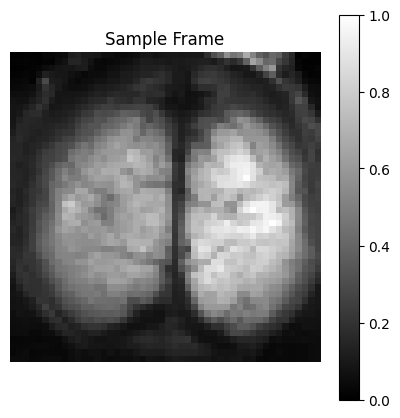

In [3]:

# --- Load video as (H, W, T) ---
video_hwt = load_video_to_array(
    VIDEO_PATH,
    to_grayscale=True,
    target_hw=TARGET_HW,
    max_frames=MAX_FRAMES,
    normalize_01=NORMALIZE_01,
)
H, W, T = video_hwt.shape
print(f"Video loaded: shape (H, W, T) = {video_hwt.shape}, dtype={video_hwt.dtype}")

# plot single frame
plt.figure(figsize=(5,5))
plt.imshow(video_hwt[:, :, T//2], cmap='gray')
plt.colorbar()
plt.title("Sample Frame")
plt.axis('off')
plt.show()

Active pixels: 571 out of 2304 (24.78%)


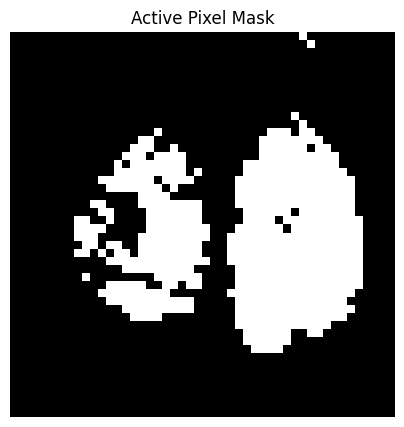

In [4]:
# --- Finding active pixels ---
std_ = np.std(video_hwt, axis=2)
mean_ = np.mean(video_hwt, axis=2)
active_mask = (std_ > 0.03) & (mean_ > 0.55)
n_active = np.sum(active_mask)
print(f"Active pixels: {n_active} out of {H*W} ({100*n_active/(H*W):.2f}%)")

# plot active mask
plt.figure(figsize=(5,5))
plt.imshow(active_mask, cmap='gray')
plt.title("Active Pixel Mask")
plt.axis('off')
plt.show()

In [5]:

# --- Reshape (H, W, T) -> (features=H*W, samples=T) -> model expects (N=samples, D=features) ---
X_flat, original_shape = reshape_video_to_matrix(video_hwt)  # (H*W, T)
X_model = X_flat.T  # (N=T, D=H*W)
X_model_active = X_model[:, active_mask.flatten()]  # (N, D_active)
print(f"X_model_active shape (N, D): {X_model_active.shape}")
print(f"X_model shape (N, D): {X_model.shape}")


X_model_active shape (N, D): (5000, 571)
X_model shape (N, D): (5000, 2304)


##### Standarization of X_model 
Only for PCA, before fitting the model.

In [6]:
# --- standardize X_model - Only for PCA ---
X_mean = np.mean(X_model_active, axis=0, keepdims=True)
X_std = np.std(X_model_active, axis=0, keepdims=True) + 1e-8
X_model_active = (X_model_active - X_mean) / X_std
#

In [7]:

# --- Fit DP-PPCA ---
ppca_res = fit_ppca_dp(
    X_model_active,
    K_max=PPCA_K_MAX,
    alpha=PPCA_ALPHA,
    draws=PPCA_DRAWS,
    tune=PPCA_TUNE,
    chains=PPCA_CHAINS,
    seed=RANDOM_SEED,
    target_accept=PPCA_TARGET_ACCEPT,
    component_threshold=PPCA_COMPONENT_THRESHOLD,
)
print(f"[PPCA] Effective K: {ppca_res.effective_K}, RMSE: {ppca_res.recon_rmse:.4f}")
# Access posterior means for W (D x K) and Z (N x K)
W_ppca = ppca_res.idata.posterior["W"].mean(dim=("chain","draw")).to_numpy()  # (D, K)
Z_ppca = ppca_res.idata.posterior["Z"].mean(dim=("chain","draw")).to_numpy()  # (N, K)
pi_ppca = ppca_res.pi_mean
print(f"[PPCA] pi mean (first 10): {np.round(pi_ppca[:10], 3)}")


sample: 100%|██████████| 1200/1200 [21:29<00:00,  1.07s/it, 255 steps of size 1.69e-02. acc. prob=0.92]
Only one chain was sampled, this makes it impossible to run some convergence checks


[PPCA] Effective K: 5, RMSE: 0.2105
[PPCA] pi mean (first 10): [0.006 0.002 0.006 0.004 0.052 0.012 0.039 0.007 0.004 0.005]


In [8]:
# --- return w_ppca to the original space ---
W_full_ppca = np.zeros((H*W, W_ppca.shape[1]), dtype=W_ppca.dtype)  # (D_full, K)
W_full_ppca[active_mask.flatten(), :] = W_ppca  # fill active pixels
W_ppca = W_full_ppca  # now W_ppca is (D_full, K)
# pi_ppca remains the same length (K)   
print(f"[PPCA] pi mean (first 10): {np.round(pi_ppca[:10], 3)}")


[PPCA] pi mean (first 10): [0.006 0.002 0.006 0.004 0.052 0.012 0.039 0.007 0.004 0.005]


[PPCA] Visualizing components: [19, 12, 4, 6, 15]


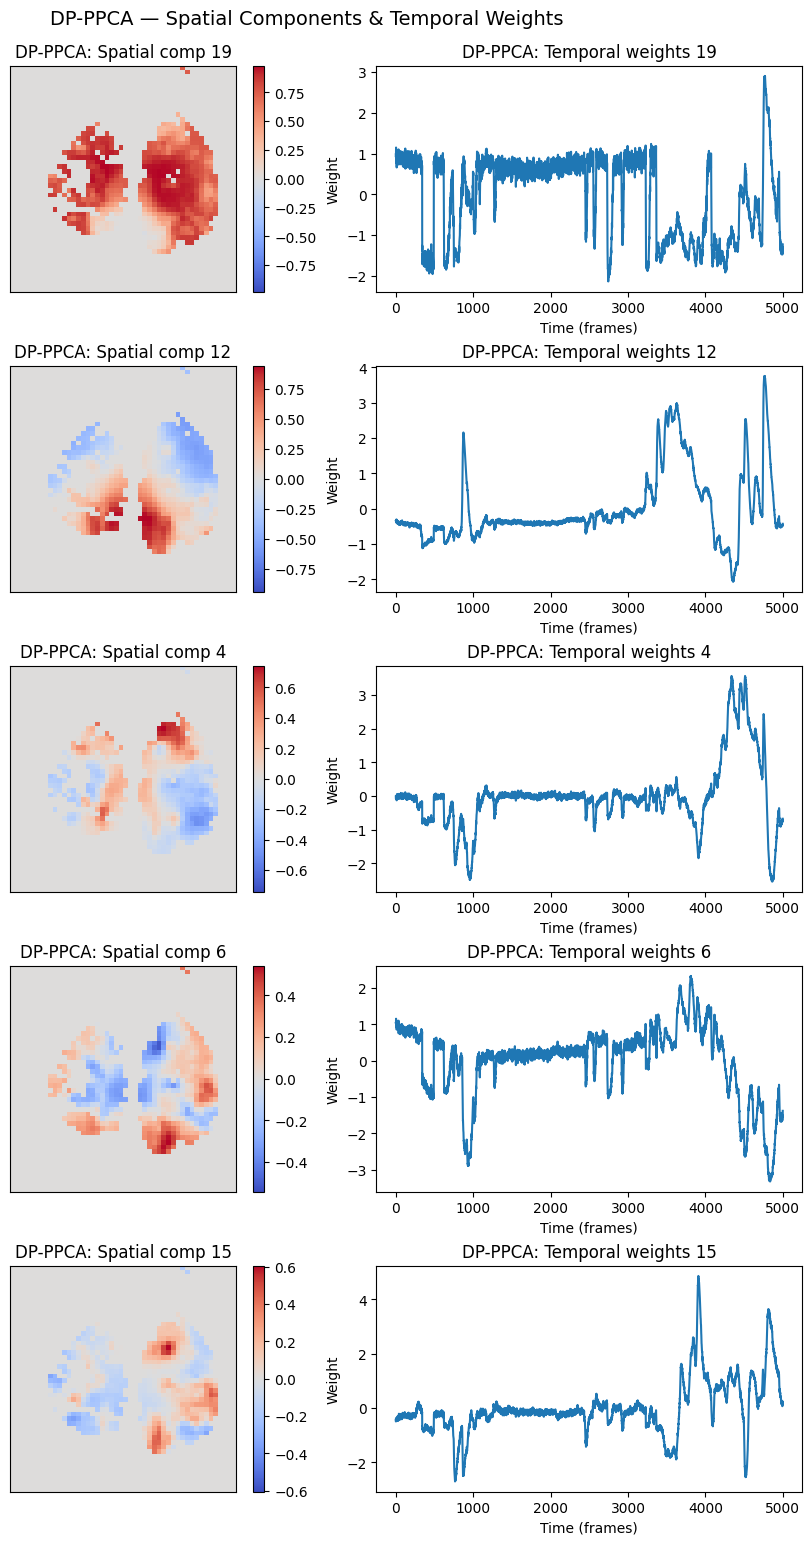

In [9]:

# --- Plot PPCA components (spatial from W, temporal from Z) ---
ppca_idxs = select_top_components(pi_ppca, k_plot=N_COMPONENTS_TO_PLOT, threshold=PPCA_COMPONENT_THRESHOLD)
print(f"[PPCA] Visualizing components: {ppca_idxs.tolist()}")
plot_components_and_time_series(
    spatial_components=W_ppca,    # columns are spatial maps
    time_series=Z_ppca,           # columns are temporal weights
    H=H,
    W=W,
    component_indices=list(ppca_idxs),
    method_name="DP-PPCA",
    save_path=os.path.join(OUTPUT_DIR, "ppca_components.png") if SAVE_FIGS else None,
    signed_spatial=True,
)


In [19]:

# --- Fit DP-NMF ---
nmf_res = fit_nmf_dp(
    X_model_active,
    K_max=NMF_K_MAX,
    alpha=NMF_ALPHA,
    draws=NMF_DRAWS,
    tune=NMF_TUNE,
    chains=NMF_CHAINS,
    seed=RANDOM_SEED + 1,
    target_accept=NMF_TARGET_ACCEPT,
    component_threshold=NMF_COMPONENT_THRESHOLD,
    use_gamma_priors=NMF_USE_GAMMA_PRIORS,
    temporal_smoothing=NMF_TEMPORAL_SMOOTHING,
    rw_sigma_scale=NMF_RW_SIGMA_SCALE,
    gamma_shape_w=NMF_GAMMA_SHAPE_W,
    gamma_rate_w=NMF_GAMMA_RATE_W,
    gamma_shape_h=NMF_GAMMA_SHAPE_H,
    gamma_rate_h=NMF_GAMMA_RATE_H,
)
print(f"[NMF] Effective K: {nmf_res.effective_K}, RMSE: {nmf_res.recon_rmse:.4f}")
# For NMF: W (N x K) are temporal weights, H (K x D) are spatial bases
W_nmf = nmf_res.idata.posterior["W"].mean(dim=("chain","draw")).to_numpy()  # (N, K)
H_nmf = nmf_res.idata.posterior["H"].mean(dim=("chain","draw")).to_numpy()  # (K, D)
pi_nmf = nmf_res.pi_mean
print(f"[NMF] pi mean (first 10): {np.round(pi_nmf[:10], 3)}")


sample: 100%|██████████| 1700/1700 [1:15:09<00:00,  2.65s/it, 1023 steps of size 1.43e-03. acc. prob=0.93]
2025-10-02 17:39:52.868396: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 6.02GiB (6464739063 bytes) by rematerialization; only reduced to 11.43GiB (12270034376 bytes), down from 11.43GiB (12270034376 bytes) originally
Only one chain was sampled, this makes it impossible to run some convergence checks


[NMF] Effective K: 4, RMSE: 0.0123
[NMF] pi mean (first 10): [0.001 0.022 0.007 0.001 0.001 0.    0.005 0.    0.002 0.003]


In [20]:
# --- return H_nmf to original space ---
# H_nmf is (K, D_active). We need a (D_full, K) buffer, fill active pixels, then transpose back to (K, D_full).
K = H_nmf.shape[0]
D_active = H_nmf.shape[1]
D_full = H * W
assert D_active == active_mask.sum(), "Mismatch between active pixels and H_nmf width"
H_full_nmf = np.zeros((D_full, K), dtype=H_nmf.dtype)  # (D_full, K)
H_full_nmf[active_mask.flatten(), :] = H_nmf.T  # place spatial bases at active pixels
H_nmf = H_full_nmf.T  # (K, D_full)
print(f"[NMF] Restored H_nmf shape: {H_nmf.shape} (K, D_full)")
print(f"[NMF] pi mean (first 10): {np.round(pi_nmf[:10], 3)}")


[NMF] Restored H_nmf shape: (20, 2304) (K, D_full)
[NMF] pi mean (first 10): [0.001 0.022 0.007 0.001 0.001 0.    0.005 0.    0.002 0.003]


[NMF] Visualizing components: [19, 1, 17, 2]


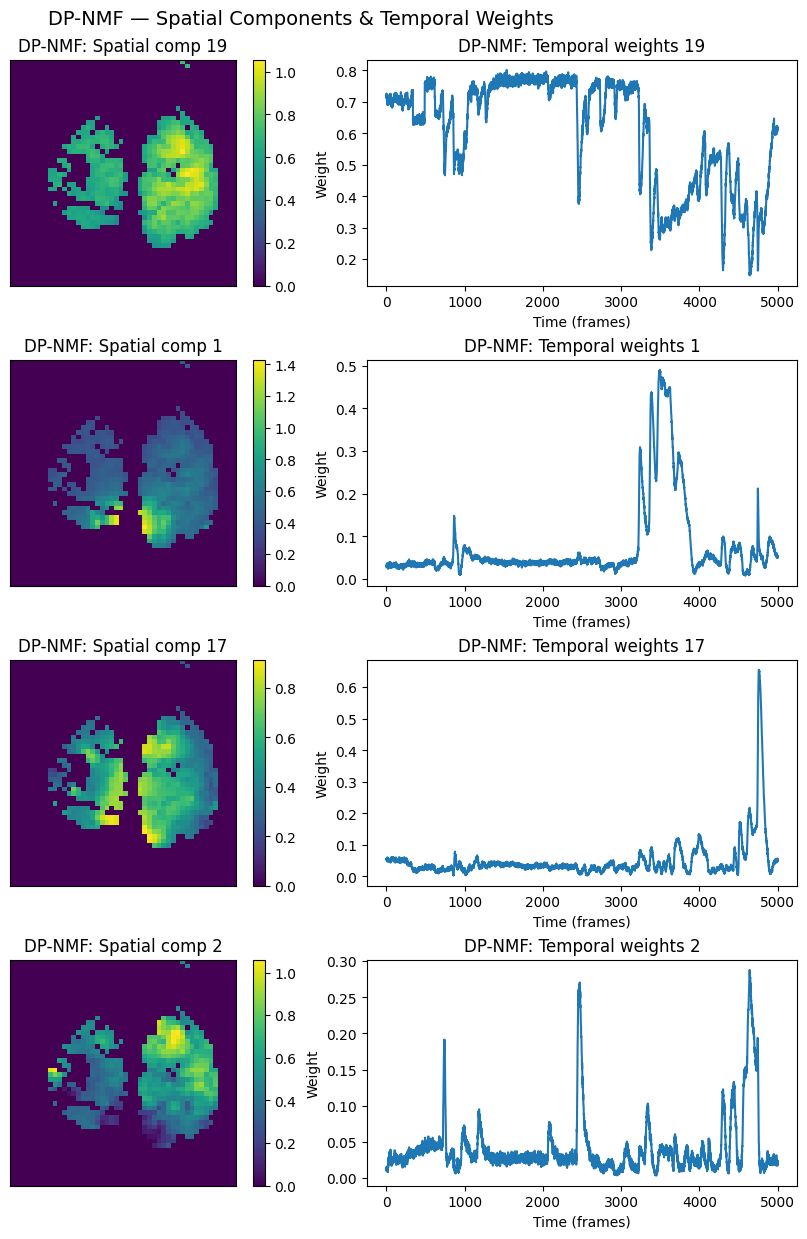

In [21]:

# --- Plot NMF components (spatial from H, temporal from W) ---
nmf_idxs = select_top_components(pi_nmf, k_plot=N_COMPONENTS_TO_PLOT, threshold=NMF_COMPONENT_THRESHOLD)
print(f"[NMF] Visualizing components: {nmf_idxs.tolist()}")

# For plotting function: spatial_components needs shape (D, K), so transpose H (K, D) -> (D, K)
plot_components_and_time_series(
    spatial_components=H_nmf.T,   # columns are spatial maps
    time_series=W_nmf,            # columns are temporal weights
    H=H,
    W=W,
    component_indices=list(nmf_idxs),
    method_name="DP-NMF",
    save_path=os.path.join(OUTPUT_DIR, "nmf_components.png") if SAVE_FIGS else None,
    signed_spatial=False,
)


In [ ]:

# --- Optional: Reconstruct and save sample frames for sanity ---
if SAVE_FIGS:
    # PPCA posterior mean reconstruction is already in ppca_res.X_mean_posterior with original feature ordering
    # But recall we passed X_model (N=T, D=H*W); reshape a few frames to images
    X_ppca_mean = ppca_res.X_mean_posterior  # shape (T, H*W)
    for t in [0, T//4, T//2, 3*T//4]:
        frame = X_ppca_mean[t].reshape(H, W)
        plt.figure(figsize=(4,4))
        plt.imshow(frame)
        plt.title(f"PPCA recon (t={t})")
        plt.axis("off")
        out = os.path.join(OUTPUT_DIR, f"ppca_recon_t{t}.png")
        plt.savefig(out, dpi=150, bbox_inches="tight"); plt.close()

    X_nmf_mean = nmf_res.X_mean_posterior  # shape (T, H*W)
    for t in [0, T//4, T//2, 3*T//4]:
        frame = X_nmf_mean[t].reshape(H, W)
        plt.figure(figsize=(4,4))
        plt.imshow(frame)
        plt.title(f"NMF recon (t={t})")
        plt.axis("off")
        out = os.path.join(OUTPUT_DIR, f"nmf_recon_t{t}.png")
        plt.savefig(out, dpi=150, bbox_inches="tight"); plt.close()

print("Done.")
